# Age-Driven Service Pressure

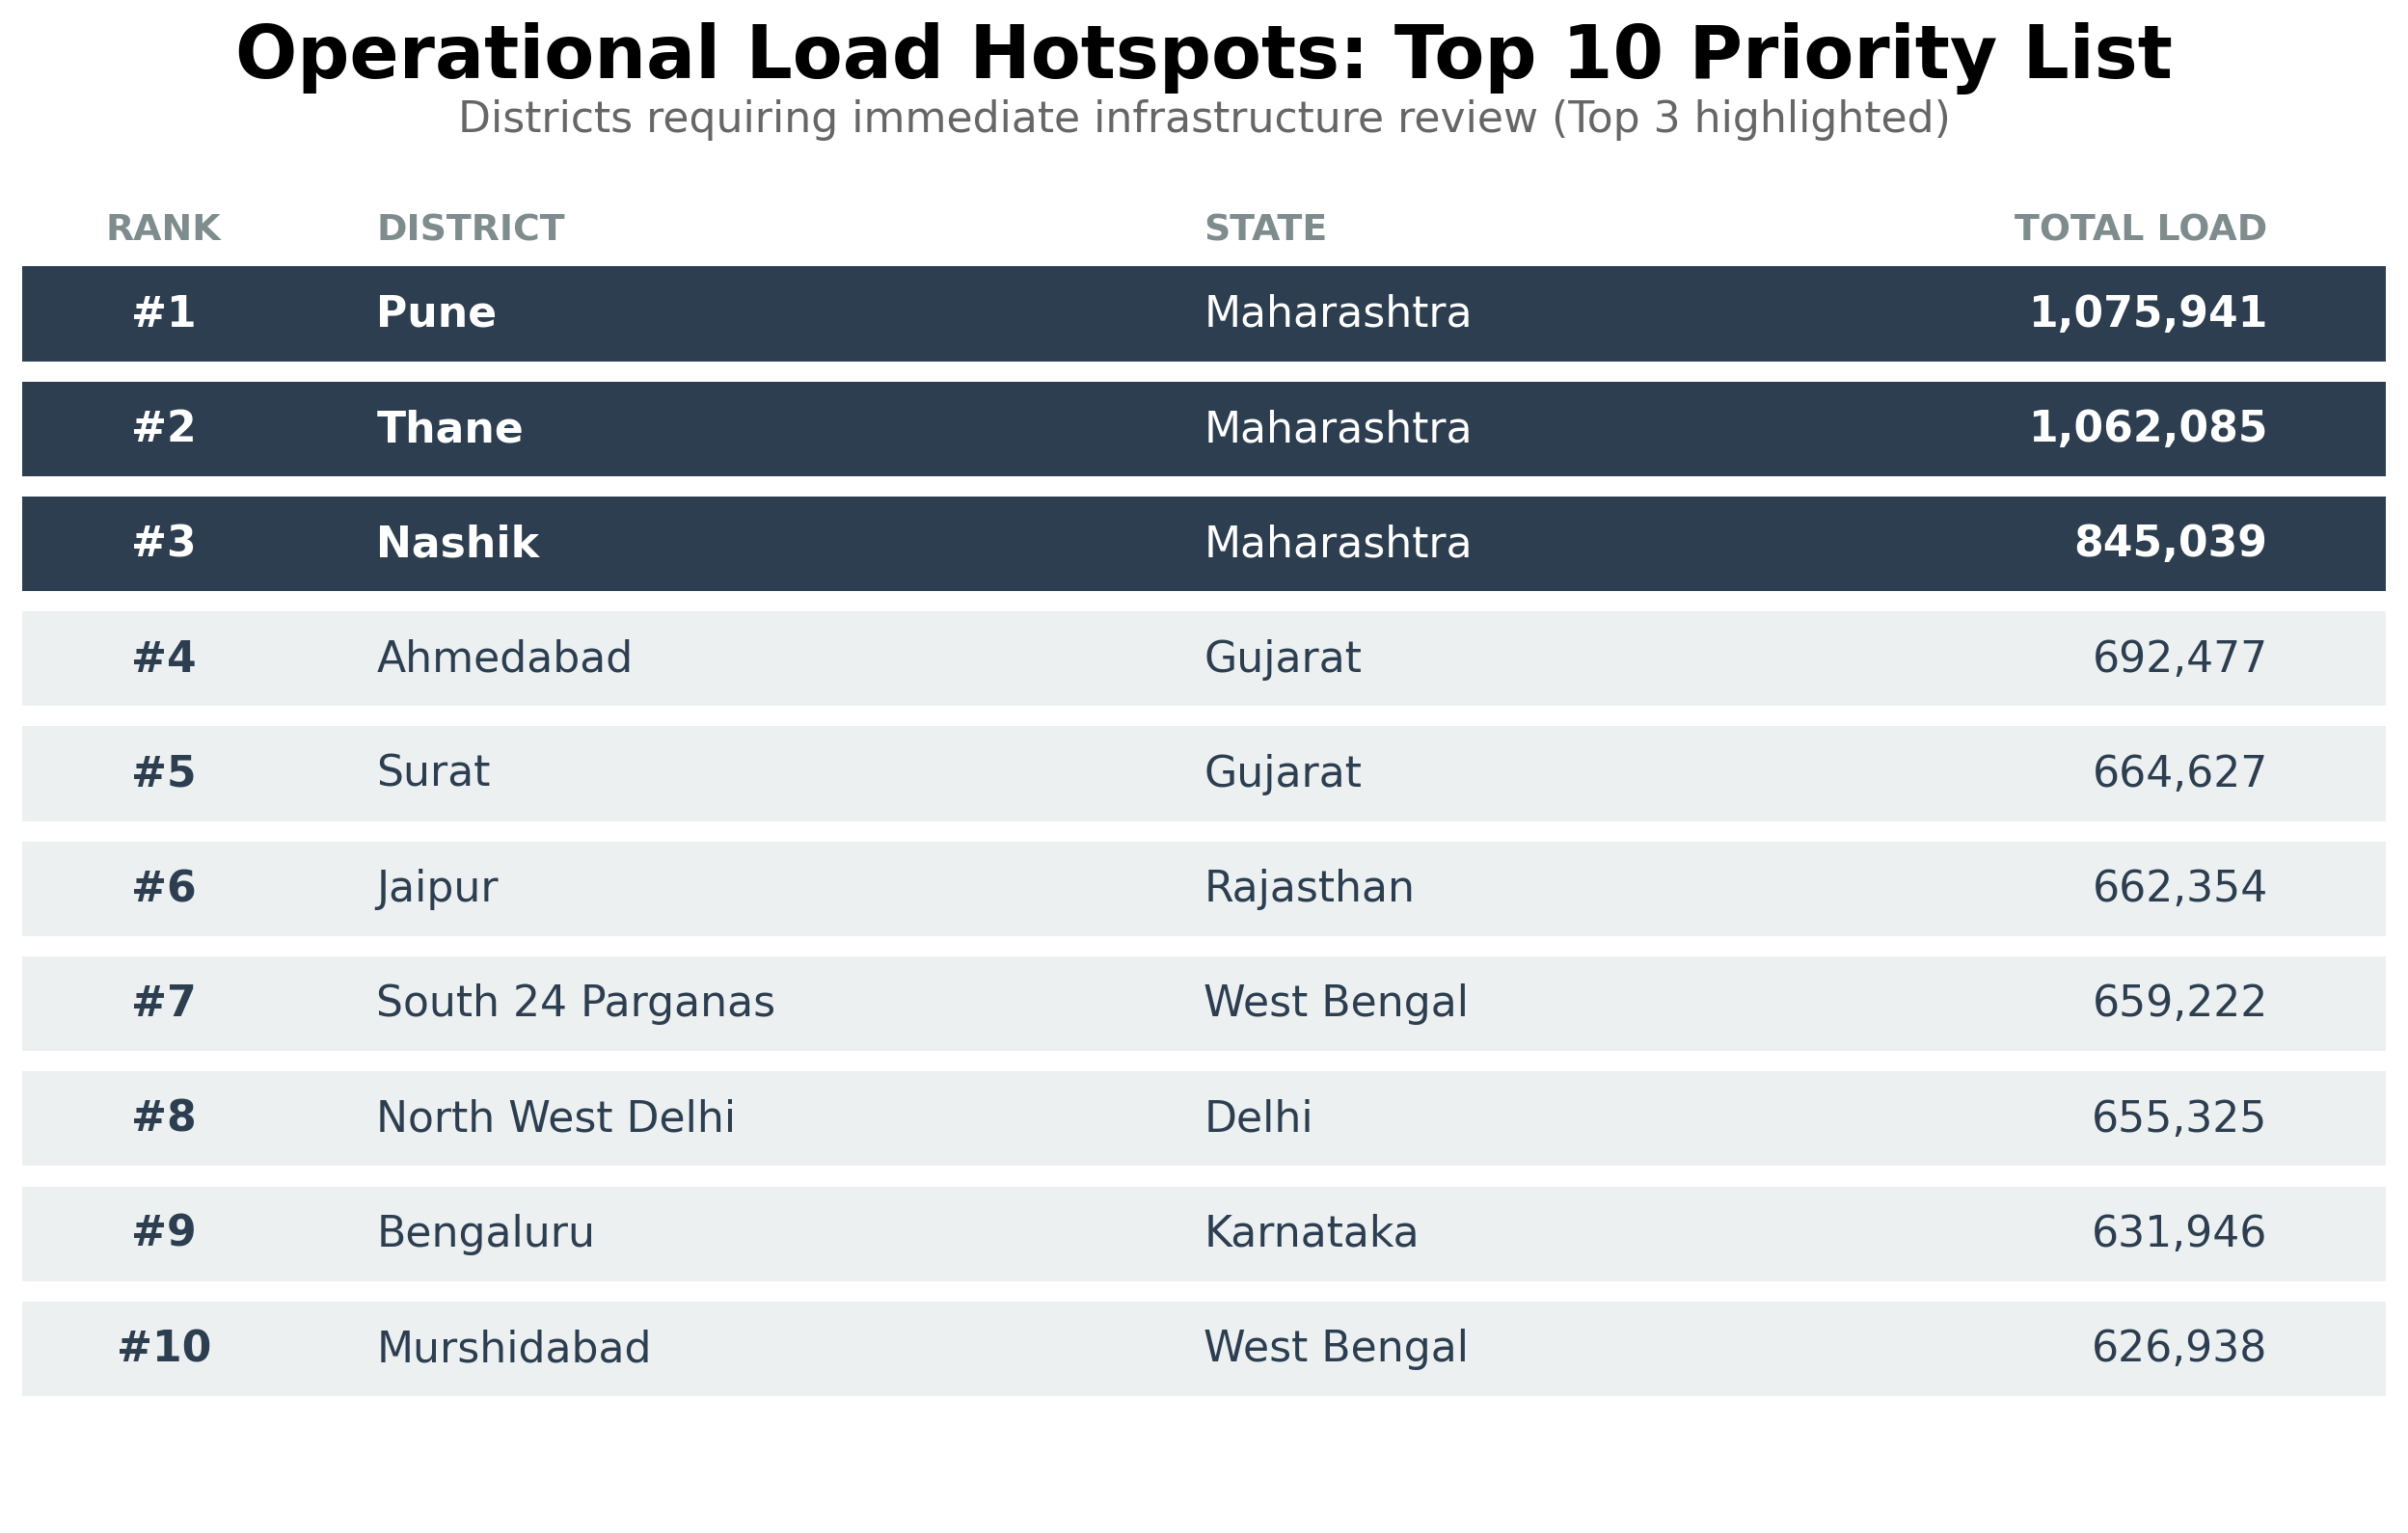

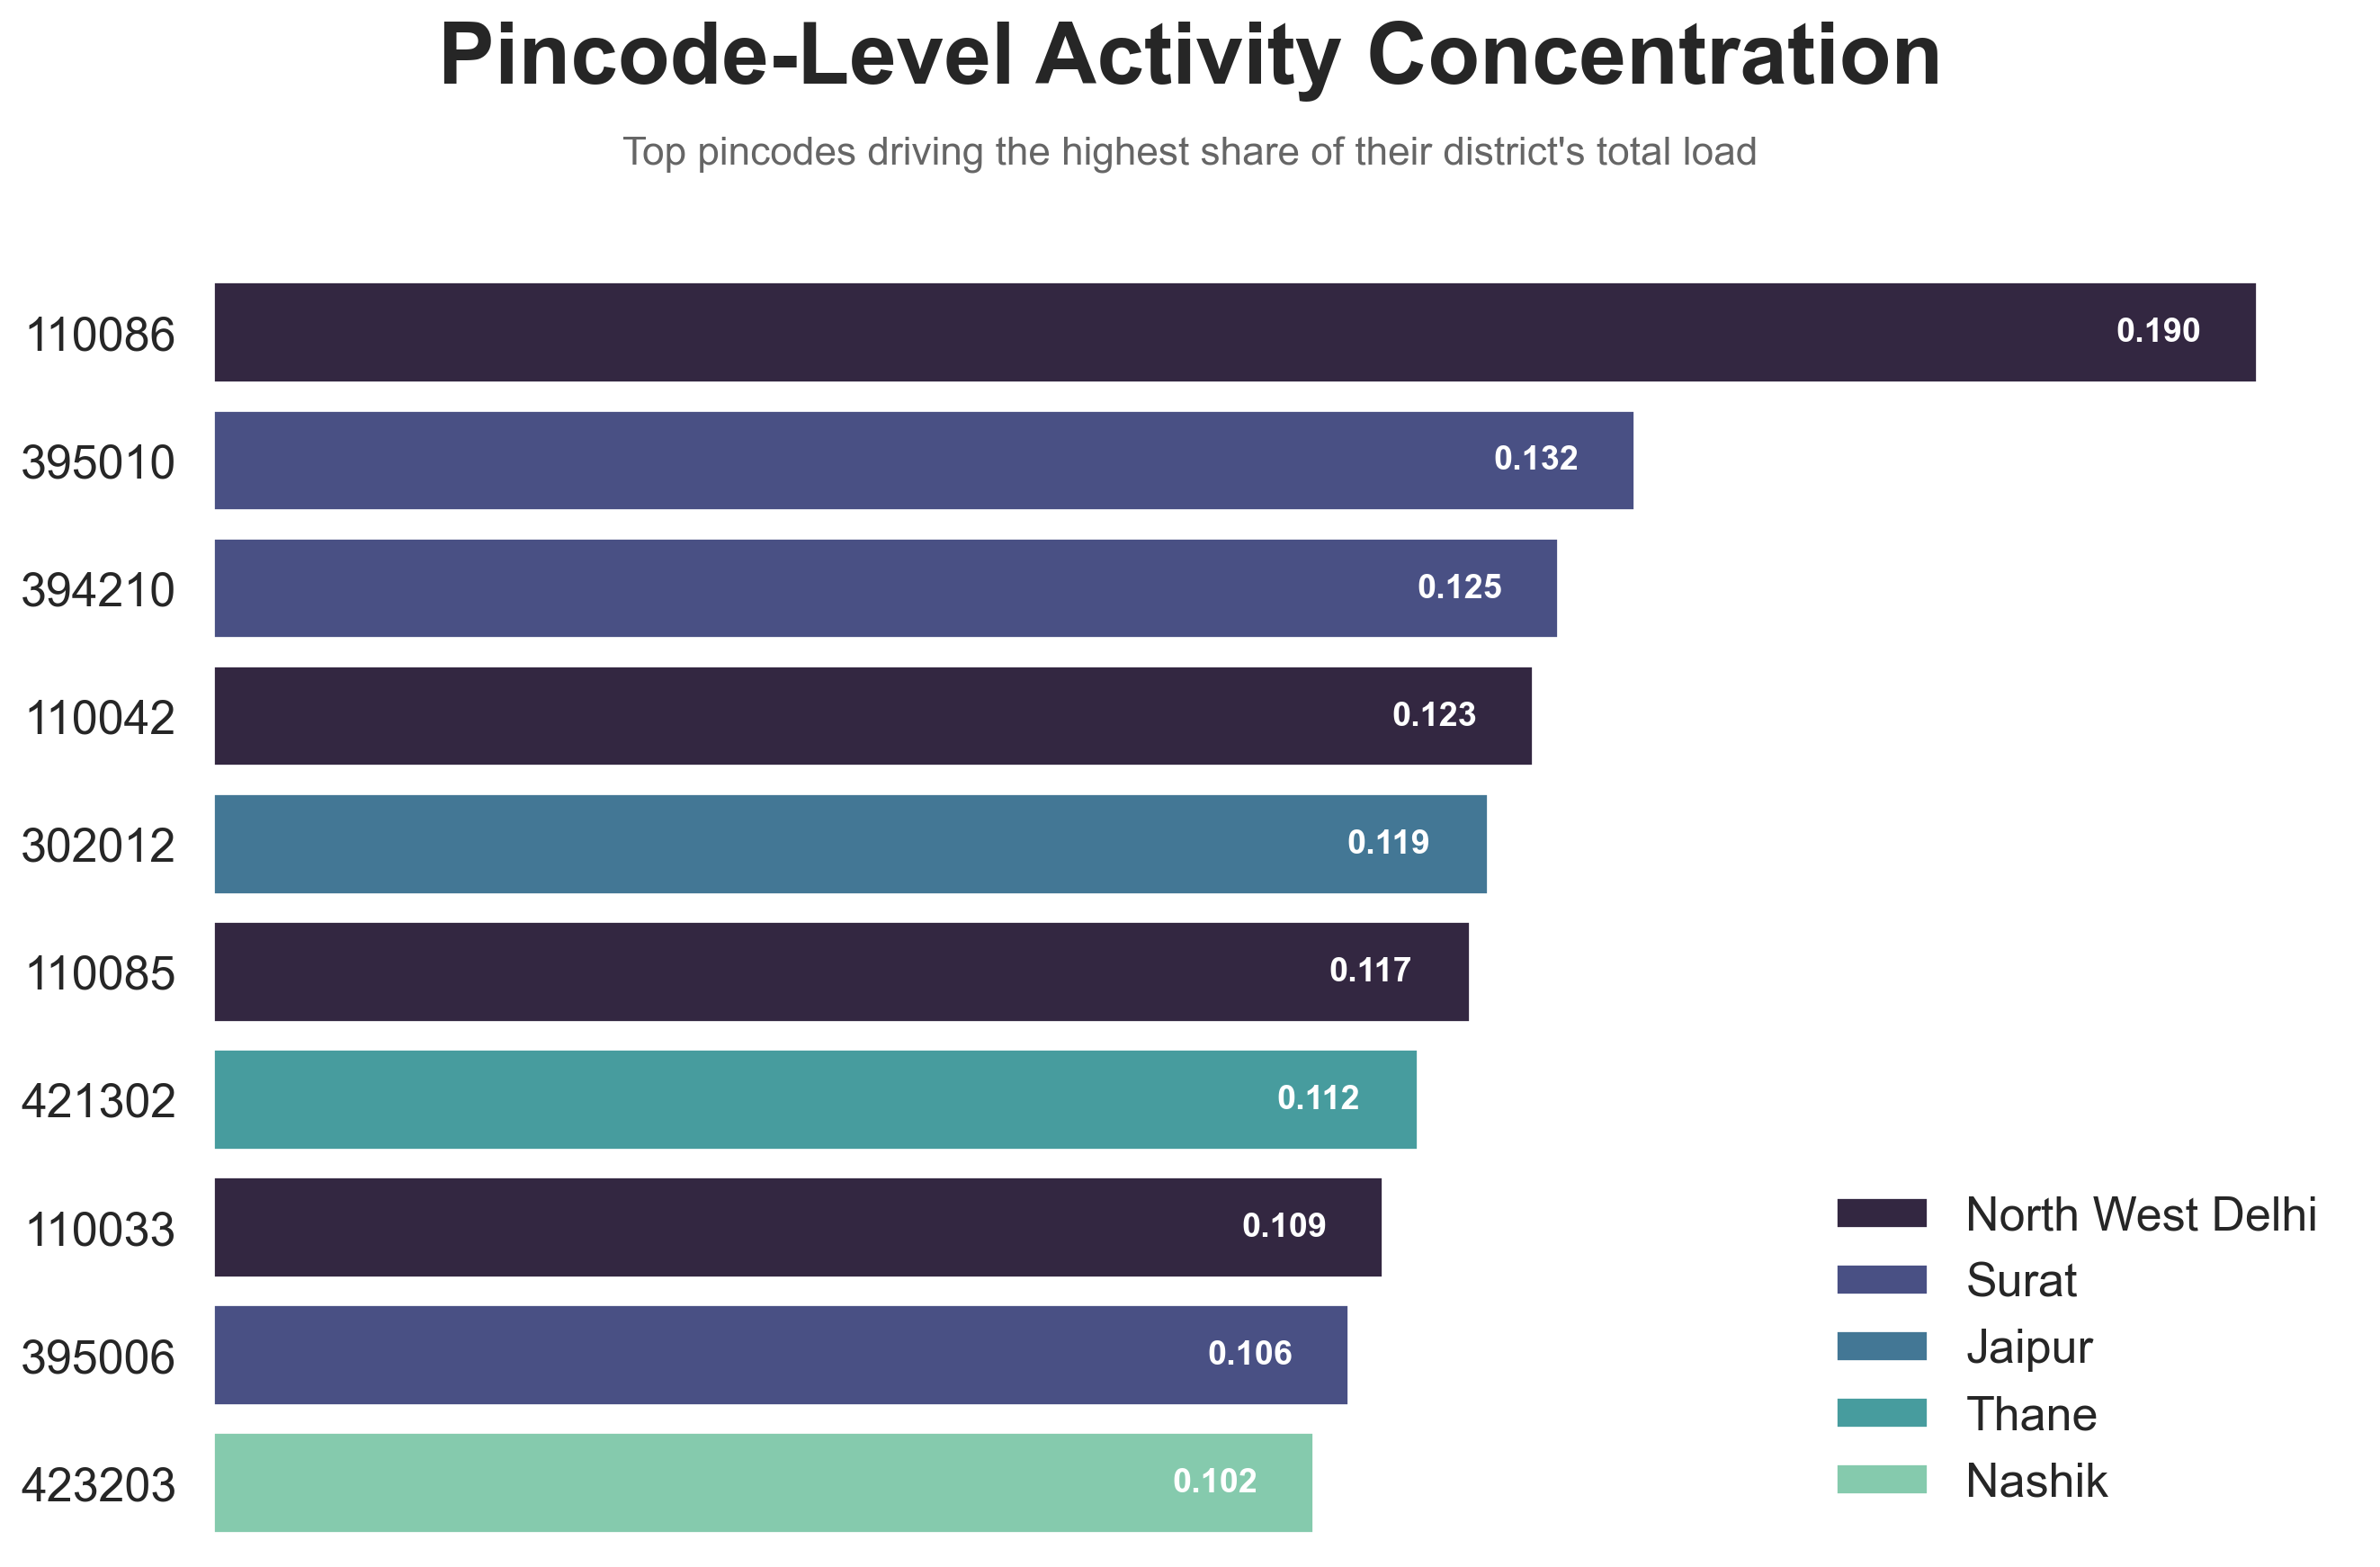

In [ ]:
from book1 import demo, bio

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["figure.dpi"] = 250          # display resolution
plt.rcParams["savefig.dpi"] = 500         # saved image quality]


sns.set_style("white")

## Aggregate Age Metrics (District Level)

In [2]:
# 1. Group Demo Activity by Age
demo_dist = demo.groupby(["state", "district"], as_index=False)[
    ["demo_age_5_17", "demo_age_17_"]
].sum()

# 2. Group Bio Activity by Age
bio_dist = bio.groupby(["state", "district"], as_index=False)[
    ["bio_age_5_17", "bio_age_17_"]
].sum()

district_df = demo_dist.merge(
    bio_dist, on=["state", "district"], suffixes=("_demo", "_bio")
)

# Calculate Total Activity by Age Group
district_df["activity_5_17"] = (
    district_df["demo_age_5_17"] + district_df["bio_age_5_17"]
)
district_df["activity_17_plus"] = (
    district_df["demo_age_17_"] + district_df["bio_age_17_"]
)

district_df = district_df[["state", "district", "activity_5_17", "activity_17_plus"]].copy()

## Core Metric: Age-Skew Ratio

In [3]:
district_df["total_update_activity"] = (
    district_df["activity_5_17"] +
    district_df["activity_17_plus"]
)

# Share of activity that is Adult (17+)
district_df["age_17_plus_share"] = (
    district_df["activity_17_plus"] /
    district_df["total_update_activity"].replace(0, np.nan)
)

In [4]:
# Filter for significant volume to avoid noise
MIN_ACTIVITY = district_df["total_update_activity"].quantile(0.75)
filtered = district_df[district_df["total_update_activity"] >= MIN_ACTIVITY].copy()

## Identify Target Zones (Adult vs Child Heavy)

In [5]:
# 1. Adult Heavy (High 17+ Share) -> Needs Permanent Centers
top10_adult_heavy = filtered.sort_values("age_17_plus_share", ascending=False).head(10)

# 2. Child Heavy (Low 17+ Share) -> Needs School Camps
top10_child_heavy = filtered.sort_values("age_17_plus_share", ascending=True).head(10)

# Calculate Median for Reference
median_val = district_df["age_17_plus_share"].median()

## Visualization

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


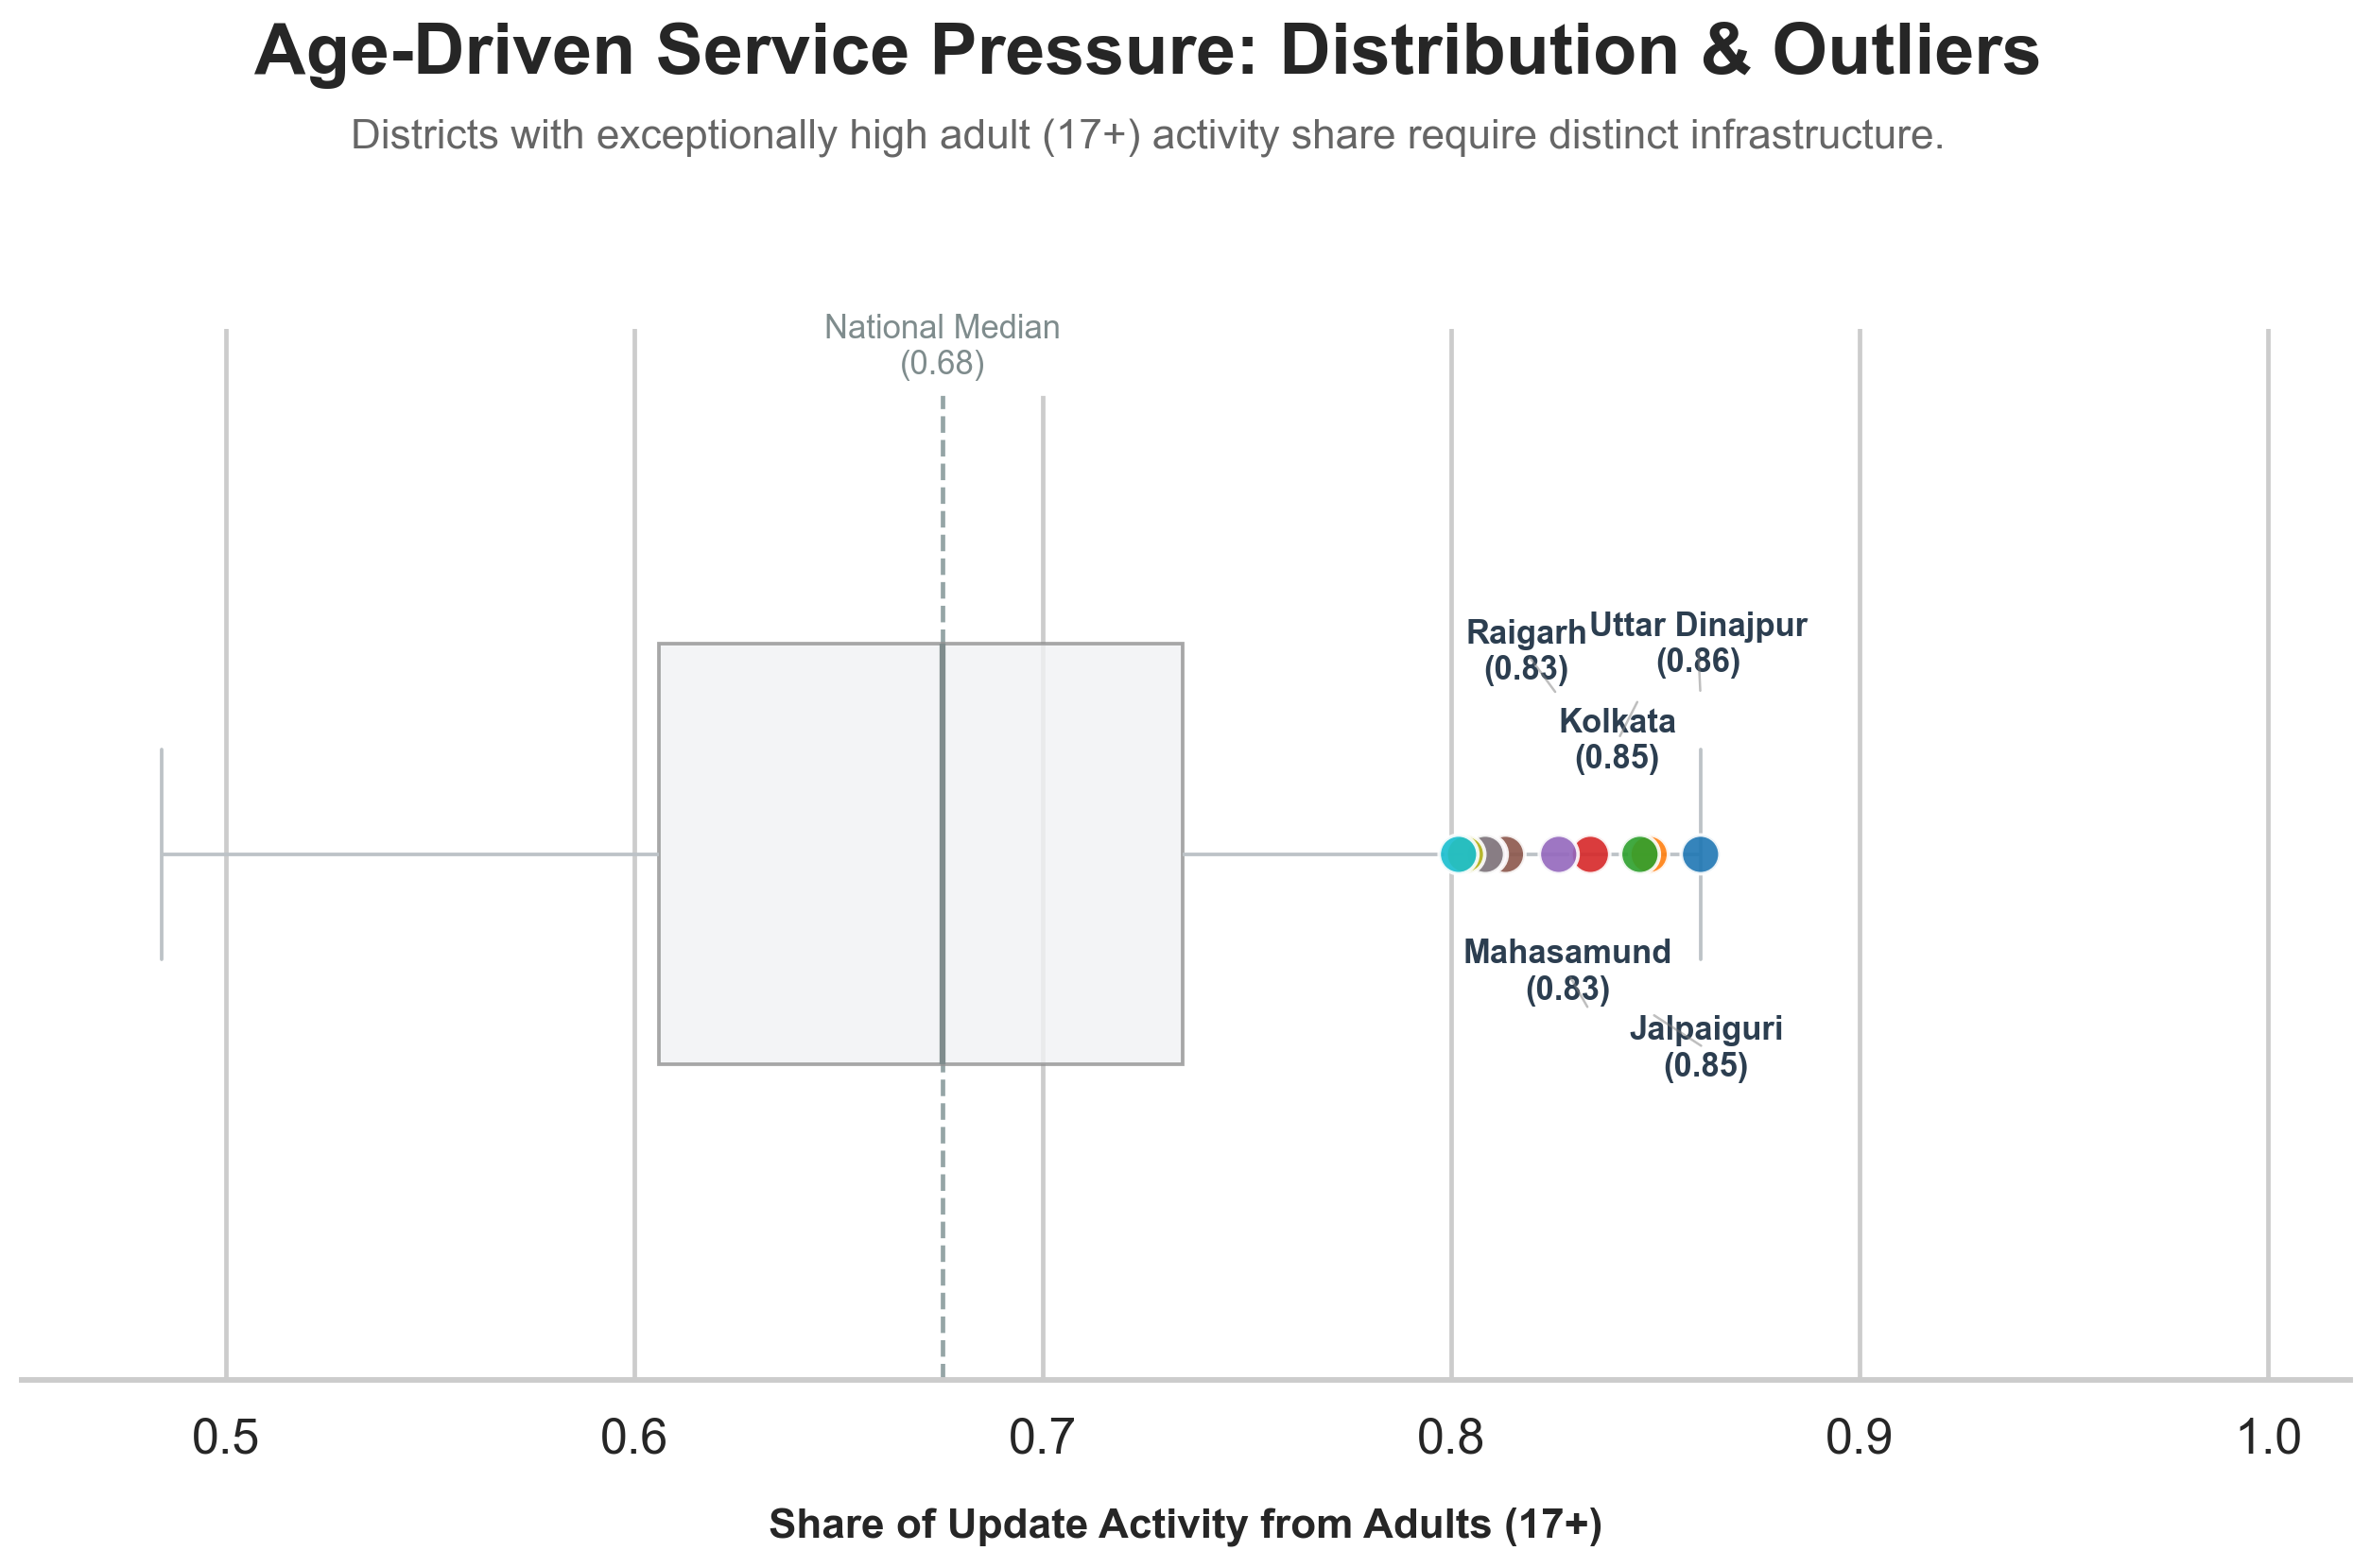

In [6]:
from adjustText import adjust_text

sns.set_context("talk")
sns.set_style("whitegrid", {'axes.facecolor': '#282a36', 'grid.color': '#44475a'})

plt.figure(figsize=[14, 7], dpi=227)
plt.gcf().patch.set_facecolor('#282a36')
plt.rcParams['text.color'] = '#f8f8f2'
plt.rcParams['axes.labelcolor'] = '#f8f8f2'
plt.rcParams['xtick.color'] = '#f8f8f2'
plt.rcParams['ytick.color'] = '#f8f8f2'

# Dracula Palette
dracula_colors = ["#ff5555", "#ffb86c", "#f1fa8c", "#50fa7b", "#8be9fd", "#bd93f9", "#ff79c6"]

# 1. The "Norm" (Boxplot)
ax = sns.boxplot(
    x=filtered["age_17_plus_share"],
    color="#44475a", # Dracula Current Line (Dark Grey)
    width=0.4,
    linewidth=1.2,
    fliersize=0,
    boxprops=dict(alpha=0.8),
    whiskerprops=dict(color='#bd93f9'), # Purple
    capprops=dict(color='#bd93f9'), # Purple
    medianprops=dict(color='#ff79c6', linewidth=2) # Pink Median
)

# 2. The "Hotspots" (Plot ALL top 10 points with UNIQUE colors)
sns.stripplot(
    data=top10_adult_heavy,
    x="age_17_plus_share",
    hue="district",
    palette=dracula_colors, # Dracula Palette
    size=13,
    jitter=False,
    alpha=0.9,
    edgecolor="#f8f8f2", # White edges
    linewidth=1.2,
    ax=ax,
    zorder=5,
    legend=False        # Hide legend since we label the dots directly
)

# 3. Label ONLY the Top 5 to prevent clutter
texts = []
for i, (idx, row) in enumerate(top10_adult_heavy.head(5).iterrows()):
    
    # We preset a slight vertical offset (alternating up/down)
    start_y = 0.15 if i % 2 == 0 else -0.15
    
    t = plt.text(
        x=row["age_17_plus_share"],
        y=start_y, 
        s=f"{row['district']}\n({row['age_17_plus_share']:.2f})",
        color="#f8f8f2", # White text
        fontsize=11,
        fontweight='bold',
        ha='center',
        va='center'
    )
    texts.append(t)

# 4. Run adjust_text
adjust_text(texts,
            x=top10_adult_heavy.head(5)["age_17_plus_share"],
            y=[0] * 5, 
            force_points=0.5,
            force_text=0.6,
            expand_points=(1.2, 1.5), 
            expand_text=(1.1, 1.2),
            arrowprops=dict(arrowstyle="-", color='#6272a4', lw=0.8, alpha=0.5) # Grey arrow
            )

# 5. Contextual Lines
median_val = filtered["age_17_plus_share"].median()
plt.axvline(median_val, color="#6272a4", linestyle="--", linewidth=1.5, zorder=0) # Comment color
plt.text(median_val, 0.45, f"National Median\n({median_val:.2f})",
         color="#ff79c6", fontsize=11, ha="center", va="bottom", backgroundcolor='#282a36') # Pink text on Dark BG

# 6. Titles & Layout
plt.figtext(0.5, 1.02, "Age-Driven Service Pressure: Distribution & Outliers",
            fontsize=24, weight='bold', ha='center', color='#f8f8f2')

plt.figtext(0.5, 0.97, "Districts with exceptionally high adult (17+) activity share require distinct infrastructure.",
            fontsize=14, color='#6272a4', ha='center')

plt.xlabel("Share of Update Activity from Adults (17+)", labelpad=15, weight='bold', fontsize=14)
plt.yticks([]) 
sns.despine(left=True) 

# Zoom in on the relevant part of the distribution
plt.xlim(0.45, 1.02)
plt.ylim(-0.5, 0.5)

plt.subplots_adjust(top=0.85, bottom=0.15)
plt.savefig("outputs/figures/book3/age_driven_service_pressure.png", bbox_inches="tight")
plt.close()

## Insight: Age-Driven Service Pressure

### The boxplot reveals that while most districts maintain a balance (Median ~0.70), extreme outliers exist where service demand is 95%+ adult-driven.

**Why this visual matters:**
By plotting the distribution, we prove that the highlighted districts (Red) are **statistically distinct** from the norm. They are not just "high"—they are structural anomalies.

**Operational Strategy:**
- **For the Outliers (Red Dots):** These districts require **permanent infrastructure** (Seva Kendras) with extra counters, as adult updates (biometrics) are time-consuming and cannot be done in camps.
- **For the Norm (Grey Box):** Standard mix of permanent centers and periodic camps is sufficient.